## **Exercise 2 : CNN Object Detection**
##### Tivani Shakilla Ervi
##### 140810170014

### **1. Import Library**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **2. Download Dataset Buah**

In [ ]:
import pathlib
dataset_url = "https://drive.google.com/drive/folders/1bnh8DM7pPqbLc_rh8EkhMJOneclW65uD"
data_dir = tf.keras.utils.get_file('Tugas CNN', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

### **3. Split Data**
Menjadi :
*   train (data latih)
*   validation (validasi untuk data latih)
*   test (data testing untuk menguji model)





In [ ]:
mypath= 'drive/MyDrive/Tugas CNN/'
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
Apel     456
Jeruk    479
Pir      492
dtype: int64

In [ ]:
#cek sample datanya
df.head()

,path,file_name,tag
0,drive/MyDrive/Tugas CNN/Tugas CNN/Pir/113_100.jpg,113_100.jpg,Pir
1,drive/MyDrive/Tugas CNN/Tugas CNN/Pir/10_100.jpg,10_100.jpg,Pir
2,drive/MyDrive/Tugas CNN/Tugas CNN/Pir/110_100.jpg,110_100.jpg,Pir
3,drive/MyDrive/Tugas CNN/Tugas CNN/Pir/109_100.jpg,109_100.jpg,Pir
4,drive/MyDrive/Tugas CNN/Tugas CNN/Pir/108_100.jpg,108_100.jpg,Pir


**Train test split**

In [ ]:
#load library untuk train test split
from sklearn.model_selection import train_test_split

#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=300)

# kemudian data test dibagi menjadi 2 sehingga menjadi data test dan data validation.
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=100)

# menyatukan kedalam masing-masing dataframe

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

print('train size', len(df_tr))
print('val size', len(df_te))
print('test size', len(df_val))

train size 1141
val size 143
test size 143


In [ ]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample(3)


set         tag  
test        Apel      46
            Jeruk     46
            Pir       51
train       Apel     366
            Jeruk    383
            Pir      392
validation  Apel      44
            Jeruk     50
            Pir       49
dtype: int64 




,path,tag,set
1097,drive/MyDrive/Tugas CNN/Tugas CNN/Jeruk/r_228_...,Jeruk,train
637,drive/MyDrive/Tugas CNN/Tugas CNN/Jeruk/124_10...,Jeruk,train
1083,drive/MyDrive/Tugas CNN/Tugas CNN/Pir/203_100.jpg,Pir,train


**Merapihkan ke folder set masing-masing**

In [ ]:
import shutil
from tqdm.notebook import tqdm as tq

datasource_path = "drive/MyDrive/Tugas CNN//"
dataset_path = "dataset/"

for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

### **4. Membuat Classifier**

In [ ]:
# Define Input Parameters
dim = (150, 150)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 10

In [ ]:
#Membuat dataset generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Mendefinisikan Data |Generatornya
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

#Mendefinisikan asal folder sumber file berasal
# binary = [1,0,0,0,0] [0,1,0,0,0] [0,0,1,0,0] [0,0,0,1,0] [0,0,0,0,1]
# categorical = 1,2,3,4,5

train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

print(labels)

Found 1141 images belonging to 3 classes.
Found 143 images belonging to 3 classes.
Found 143 images belonging to 3 classes.
dict_keys(['Apel', 'Jeruk', 'Pir'])


In [ ]:
#Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

### **5. Membuat Struktur CNN**

In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

#Manually Define Network
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Compiling Model.......
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 128)     3584      
_________________________________________________________________
activation_6 (Activation)    (None, 150, 150, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 148, 148, 32)      36896     
_________________________________________________________________
activation_7 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (N

### **6. Menggunakan Pre-trained model / Transfer Learning**

In [ ]:
#Build Base Model

from tensorflow.keras.applications import MobileNetV2

# get base models
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class,
)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#Add top layer network

from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [ ]:
#Effinet
!pip install -U --pre efficientnet
from efficientnet.tfkeras import EfficientNetB1

# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

     |████████████████████████████████| 51kB 3.0MB/s 
27017216/27010080 [==============================] - 0s 0us/step


In [ ]:
#Add top network layer to models
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 32)   0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [ ]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


### **7. Visualisasi Model Akhir**

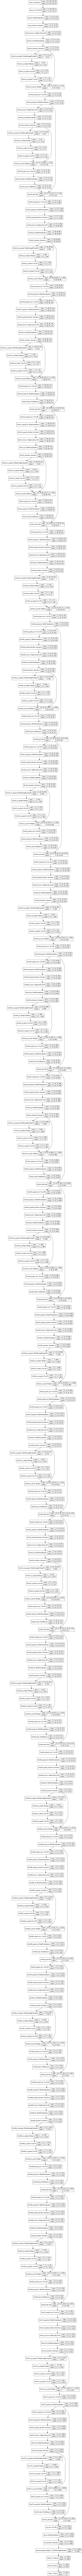

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

### **8. Train Model**

In [ ]:
EPOCH = 2
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/2
72/72 [==============================] - 203s 3s/step - loss: 0.1256 - accuracy: 0.9553 - val_loss: 0.0438 - val_accuracy: 0.9930
Epoch 2/2
72/72 [==============================] - 200s 3s/step - loss: 0.0636 - accuracy: 0.9790 - val_loss: 0.6652 - val_accuracy: 0.9091


In [ ]:
history.history['loss']

[0.1255895495414734, 0.06364588439464569]

In [ ]:
history.history['accuracy']

[0.955302357673645, 0.9789658188819885]

### **9. Plot Training**

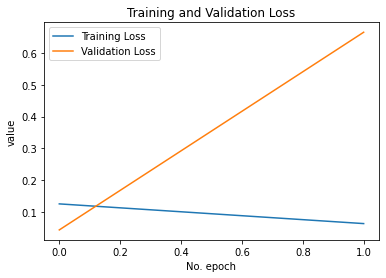

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

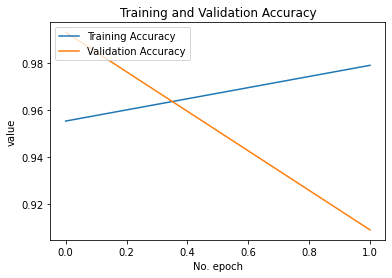

In [ ]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

### **10. Menyimpan Model**

In [ ]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "medium_project"
SAVE_MODEL_NAME = "model.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

### **11. Evaluasi Model**

In [ ]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

### **12. Mendefinisikan Parameter**

In [60]:
import requests
from io import BytesIO

from PIL import Image
import numpy as np

# Parameters
input_size = (150,150)

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['apel', 'jeruk', 'pir']

## **13. Mendefinisikan Fungsi Preprosesing**

In [63]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [64]:
#Load Model

from tensorflow.keras.models import load_model
MODEL_PATH = 'model/medium_project/model.h5'

### **14. Prediksi Data Testing**

Saving pir.jpg to pir (2).jpg
pir.jpg
===Ini Pir===


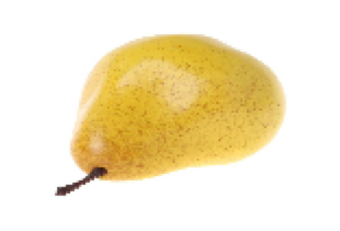

In [87]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files

%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(100,150,3))
  plt.axis('off')
  plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  if classes[0][0]==1:
    print('===Ini Apel===')
  elif classes[0][1]==1:
    print('===Ini Jeruk===')
  else:
    print('===Ini Pir===')

### **TESTING DENGAN PERSENTASE**

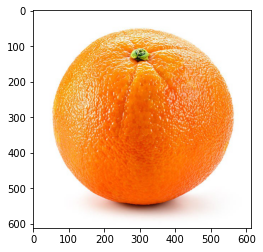

jeruk 1.0


In [89]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('test.jpg')
imgplot = plt.imshow(img)
plt.show()

# read image
im = Image.open('test.jpg') #masukkan data testing disini
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )